In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### EDA + cleaning

In [2]:
## Read filmweb data
df_filmweb = pd.read_csv("data/filmweb.csv")
df_filmweb.head()

,title,originalTitle,description,genre
0,Zielona mila,The Green Mile,Emerytowany strażnik więzienny opowiada przyja...,Dramat
1,Skazani na Shawshank,The Shawshank Redemption,Adaptacja opowiadania Stephena Kinga. Niesłusz...,Dramat
2,Forrest Gump,NaN,"Historia życia Forresta, chłopca o niskim ilor...",Dramat / Komedia
3,Leon zawodowiec,Léon,Płatny morderca ratuje dwunastoletnią dziewczy...,Dramat / Kryminał
4,Requiem dla snu,Requiem for a Dream,"Historia czwórki bohaterów, dla których używki...",Dramat


In [3]:
## Read train imdb data
df_imdb_1 = pd.read_csv('data/train_data.txt', sep=":::", header=None, engine='python')
df_imdb_1.columns = ['id', 'title', 'genre', 'description']
df_imdb_1 = df_imdb_1.drop(columns=["id"])

In [4]:
## Read test imdb data
df_imdb_2 = pd.read_csv('data/test_data_solution.txt', sep=":::", header=None, engine='python')
df_imdb_2.columns = ['id', 'title', 'genre', 'description']
df_imdb_2 = df_imdb_2.drop(columns=["id"])

In [5]:
## Combine the imdb datasets to create one big dataset
df_imdb_all = pd.concat([df_imdb_1, df_imdb_2], axis=0).reset_index(drop=True)

In [6]:
## Compare the sizes of two datasets
print(f"Number of samples in filmweb dataset {df_filmweb.shape[0]:,}")
print(f"Number of samples in imdb dataset {df_imdb_all.shape[0]:,}")

Number of samples in filmweb dataset 9,943
Number of samples in imdb dataset 108,414


In [7]:
## Check for Nan's

In [8]:
## We can get the "originalTitle" from the title column
## Because if the title is the same as originalTitle then the second column
## has a NaN as an entry
df_filmweb.isna().sum()

title               0
originalTitle    2366
description         0
genre               0
dtype: int64

In [9]:
df_imdb_all.isna().sum()

title          0
genre          0
description    0
dtype: int64

In [10]:
## If the "originalTitle" is None then the "title" is the "originalTitle"
df_filmweb["originalTitle"][df_filmweb["originalTitle"].isna()] = df_filmweb["title"][df_filmweb["originalTitle"].isna()]

## Let's also drop the "title" column because it's no longer needed and rename the "originalTitle" column to "title"
df_filmweb = df_filmweb.drop(columns="title").rename({"originalTitle": "title"}, axis=1)

In [11]:
## Check again for missing values for filmweb dataset
df_filmweb.isna().sum()

title          0
description    0
genre          0
dtype: int64

In [12]:
## Check unique genres in each move database

In [13]:
df_imdb_all.genre.nunique()

27

In [14]:
## Let's inspect what's going on here
df_filmweb.genre.nunique()

959

In [15]:
## As we can probably deduce a movie can belong to multiple genre
## For the sake of comparison with imdb dataset let's
## only take the first occuring genre as the "true" genre of the movie
## But before that let's first check for the existance of the same
## movies in both datasets, so we can compare them later
df_filmweb.genre.value_counts(normalize=True)

Dramat                                   0.104395
Komedia                                  0.049381
Horror                                   0.049180
Dramat / Komedia                         0.038419
Thriller                                 0.035502
                                           ...   
Sportowy                                 0.000101
Sensacyjny / Psychologiczny              0.000101
Dramat / Kryminał / Wojenny              0.000101
Biograficzny / Komedia / Wojenny         0.000101
Dramat / Komedia / Kryminał / Musical    0.000101
Name: genre, Length: 959, dtype: float64

Let's inspect how the title of both datasets look like

In [16]:
df_filmweb.title

0                 The Green Mile
1       The Shawshank Redemption
2                   Forrest Gump
3                           Léon
4            Requiem for a Dream
                  ...           
9938                  Dark Angel
9939          Pożegnanie z Marią
9940                         Rh+
9941     Wet Hot American Summer
9942                The Sicilian
Name: title, Length: 9943, dtype: object

In [17]:
df_imdb_all.title

0              Oscar et la dame rose (2009) 
1                              Cupid (1997) 
2          Young, Wild and Wonderful (1980) 
3                     The Secret Sin (1915) 
4                    The Unrecovered (2007) 
                         ...                
108409       "Tales of Light & Dark" (2013) 
108410          Der letzte Mohikaner (1965) 
108411                  Oliver Twink (2007) 
108412                    Slipstream (1973) 
108413            Curitiba Zero Grau (2010) 
Name: title, Length: 108414, dtype: object

Unfortunately the imdb dataset contains also the year in which the movie was released(probably), therefore right now we won't be able to check if there are any movies that belong to both datasets, so let's clean the title column in both of the datasets <br>
The cleaning consists of deleting the "(year)" part from each title and also dropping the special characters and making each of them a lower case character.

In [18]:
## preprocessing 
def clean_titles(ser: pd.Series) -> pd.Series:
    ser = ser.copy()


    ser = (ser
    .str
    .replace(pat=r"(\([a-zA-Z0-9./?]+\))|([\'\"])", repl="", regex=True)
    .str
    .strip()
    .str
    .normalize("NFKD")
    .str
    .encode("ascii", errors="ignore")
    .str
    .decode("utf-8")
    .str
    .lower()
    )
    return ser


def first_genre_filmweb(df_, genres):
    ## Słowniczek
    mapping = {"dramat": "drama", "komedia": "comedy", "dokumentalny": "documentary", "krótkometrażowy": "short",
              "akcja": "action", "melodramat": "drama", "familijny": "family", "przygodowy": "adventure",
              "muzyczny": "music", "romans": "romance",  "sensacyjny": "thriller", "biograficzny": "biography",
              "animacja": "animation", "dramat obyczajowy": "drama", "dramat historyczny": "drama",
              "dramat sądowy": "drama", "wojenny": "war", "kryminał": "crime", "psychologiczny": "thriller",
              "komedia rom.": "comedy", "komedia kryminalna": "comedy", "komedia obycz.": "comedy"}
    
    df_ = df_.copy()

    df_ = (df_
            .assign(genre = lambda df_d: df_d
                ["genre"]
                .str
                .split(" / ")
                .apply(lambda v: v[0])
                .str
                .lower()
                .replace(mapping))
            .loc[lambda v: v.genre.isin(genres)])
    return df_


def explode_genres_filmweb(df_):
    
    ## Słowniczek
    mapping = {"dramat": "drama", "komedia": "comedy", "dokumentalny": "documentary", "krótkometrażowy": "short",
              "akcja": "action", "melodramat": "drama", "familijny": "family", "przygodowy": "adventure",
              "muzyczny": "music", "romans": "romance",  "sensacyjny": "thriller", "biograficzny": "biography",
              "animacja": "animation", "dramat obyczajowy": "drama", "dramat historyczny": "drama",
              "dramat sądowy": "drama", "wojenny": "war", "kryminał": "crime", "psychologiczny": "thriller",
              "komedia rom.": "comedy", "komedia kryminalna": "comedy", "komedia obycz.": "comedy"}
    
    df_ = df_.copy()
    
    df_ = (df_
            .assign(genre=lambda df_d: df_d
                  ["genre"]
                  .str
                  .split(" / "))
            .explode("genre")
            .assign(genre=lambda df_d: df_d
                 ["genre"]
                 .str
                 .lower()
                 .replace(mapping))
        )
    
    
    return df_

In [19]:
## Cleanin'
titles_filmweb = df_filmweb["title"].pipe(clean_titles)
titles_imdb = df_imdb_all["title"].pipe(clean_titles)

In [20]:
## Let's check how many titles belong to both datasets
len(set(titles_filmweb) & set(titles_imdb))

2024

In [21]:
## Let's replace the the titles with the cleaned ones
df_filmweb["title"] = df_filmweb["title"].pipe(clean_titles)
df_imdb_all["title"] = df_imdb_all["title"].pipe(clean_titles)

In [22]:
df_filmweb

,title,description,genre
0,the green mile,Emerytowany strażnik więzienny opowiada przyja...,Dramat
1,the shawshank redemption,Adaptacja opowiadania Stephena Kinga. Niesłusz...,Dramat
2,forrest gump,"Historia życia Forresta, chłopca o niskim ilor...",Dramat / Komedia
3,leon,Płatny morderca ratuje dwunastoletnią dziewczy...,Dramat / Kryminał
4,requiem for a dream,"Historia czwórki bohaterów, dla których używki...",Dramat
...,...,...,...
9938,dark angel,Policyjny detektyw zostaje wplątany w zagrażaj...,Thriller / Sci-Fi
9939,pozegnanie z maria,Grupa młodych ludzi próbuje zachować resztki n...,Melodramat / Wojenny
9940,rh+,Rh (+) to opowieść o grupie dwudziestokilkule...,Kryminał / Sensacyjny
9941,wet hot american summer,"Grupa opiekunów letniego obozu, podczas ostatn...",Komedia rom.


In [23]:
df_imdb_all = df_imdb_all.iloc[:, [0,2,1]]
## I've seen that the genre column in imdb dataset was padded with spaces
## and the belowe cell with filmweb data manipulation did not work because of that
## so I've stripped it from those spaces
df_imdb_all["genre"] = df_imdb_all["genre"].str.strip()
df_imdb_all

,title,description,genre
0,oscar et la dame rose,Listening in to a conversation between his do...,drama
1,cupid,A brother and sister with a past incestuous r...,thriller
2,"young, wild and wonderful",As the bus empties the students for their fie...,adult
3,the secret sin,To help their unemployed father make ends mee...,drama
4,the unrecovered,The film's title refers not only to the un-re...,drama
...,...,...,...
108409,tales of light & dark,"Covering multiple genres, Tales of Light & Da...",horror
108410,der letzte mohikaner,As Alice and Cora Munro attempt to find their...,western
108411,oliver twink,A movie 169 years in the making. Oliver Twist...,adult
108412,slipstream,"Popular, but mysterious rock D.J Mike Mallard...",drama


In [24]:
## Okey so now that we have cleaned titles let's clean the genres for filmweb dataset
df_filmweb = df_filmweb.pipe(first_genre_filmweb, set(df_imdb_all.genre))
df_filmweb

,title,description,genre
0,the green mile,Emerytowany strażnik więzienny opowiada przyja...,drama
1,the shawshank redemption,Adaptacja opowiadania Stephena Kinga. Niesłusz...,drama
2,forrest gump,"Historia życia Forresta, chłopca o niskim ilor...",drama
3,leon,Płatny morderca ratuje dwunastoletnią dziewczy...,drama
4,requiem for a dream,"Historia czwórki bohaterów, dla których używki...",drama
...,...,...,...
9938,dark angel,Policyjny detektyw zostaje wplątany w zagrażaj...,thriller
9939,pozegnanie z maria,Grupa młodych ludzi próbuje zachować resztki n...,drama
9940,rh+,Rh (+) to opowieść o grupie dwudziestokilkule...,crime
9941,wet hot american summer,"Grupa opiekunów letniego obozu, podczas ostatn...",comedy


In [25]:
## Let's once again see how many movies are the same in both datasets
## We've lost some movies due to "genre missmatch"(might think about it later)
titles_filmweb = df_filmweb["title"].pipe(clean_titles)
titles_imdb = df_imdb_all["title"].pipe(clean_titles)
len(set(titles_filmweb) & set(titles_imdb))

1976

In [26]:
## Let's also check how many movies that belong to both datasets have the same genre
## Not bad, 1178 movies belong to the same genres according to both datasets
len( set(zip(df_filmweb.title, df_filmweb.genre)) & set(zip(df_imdb_all.title, df_imdb_all.genre)) )

1178

In [27]:
unique_genres_imdb = df_imdb_all.genre.str.strip().unique()

In [28]:
boolean_mask = df_filmweb.genre.isin(unique_genres_imdb)

In [29]:
df_filmweb = df_filmweb[boolean_mask].reset_index(drop=True)

In [30]:
df_filmweb.groupby("genre").size().sort_values(ascending=False)

genre
drama          3899
comedy         1458
thriller        899
horror          696
biography       539
animation       393
action          322
fantasy         281
family          251
crime           244
documentary     243
adventure       162
sci-fi           57
western          53
romance          43
musical          28
war              17
short             7
music             6
dtype: int64

In [31]:
df_imdb_all.groupby("genre").size().sort_values(ascending=False)

genre
drama          27225
documentary    26192
comedy         14893
short          10145
horror          4408
thriller        3181
action          2629
western         2064
reality-tv      1767
family          1567
adventure       1550
music           1462
romance         1344
sci-fi          1293
adult           1180
crime           1010
animation        996
sport            863
talk-show        782
fantasy          645
mystery          637
musical          553
biography        529
history          486
game-show        387
news             362
war              264
dtype: int64

We would prorably have to think about what to do with movies that have less than {n} number of samples because it would be hard to get anything meaningful from them

In [32]:
def down_sample_both_dfs(df1, df2, n=1):
    same_genres = set(df1.genre) & set(df2.genre)
    print(f"Genres without the threshold: {same_genres}\n")
    groupped_df1 = df1.groupby("genre")
    groupped_df2 = df2.groupby("genre")
    
    ## TODO: Some implementation that will exclude the movies with less than n number of samples
    ## in one of the dataset
    
    groupped_df1_sizes = groupped_df1.size()
    groupped_df2_sizes = groupped_df2.size()

    genres_df1_n = groupped_df1_sizes[groupped_df1_sizes >= n].index
    genres_df2_n = groupped_df2_sizes[groupped_df2_sizes >= n].index

    same_genres_n = set(genres_df1_n) & set(genres_df2_n)
    print(f"Genres with the inclusion threshold of {n}: {same_genres_n}\n")
    
    mins_for_every_genre = {key: min(groupped_df1_sizes[key], groupped_df2_sizes[key]) for key in same_genres_n}

    print("Minimal values for each genre:")
    print(mins_for_every_genre)
    
    df1_new_beggining = pd.DataFrame()
    df2_new_beggining = pd.DataFrame()
    
    for key, value in mins_for_every_genre.items():
#         print(groupped_df1[key].sample(n=value))
        df1_new_beggining = pd.concat([df1_new_beggining, df1[df1["genre"] == key].sample(n=value, random_state=42)], axis=0)
        df2_new_beggining = pd.concat([df2_new_beggining, df2[df2["genre"] == key].sample(n=value, random_state=42)], axis=0)
    return df1_new_beggining.reset_index(drop=True), df2_new_beggining.reset_index(drop=True)
    

In [33]:
df_filmweb_sampled, df_imdb_all_sampled = down_sample_both_dfs(df_filmweb, df_imdb_all, 50)

Genres without the threshold: {'romance', 'biography', 'horror', 'short', 'documentary', 'family', 'adventure', 'western', 'fantasy', 'sci-fi', 'music', 'musical', 'thriller', 'war', 'crime', 'action', 'animation', 'drama', 'comedy'}

Genres with the inclusion threshold of 50: {'documentary', 'sci-fi', 'crime', 'family', 'action', 'biography', 'animation', 'horror', 'drama', 'adventure', 'comedy', 'thriller', 'western', 'fantasy'}

Minimal values for each genre:
{'documentary': 243, 'sci-fi': 57, 'crime': 244, 'family': 251, 'action': 322, 'biography': 529, 'animation': 393, 'horror': 696, 'drama': 3899, 'adventure': 162, 'comedy': 1458, 'thriller': 899, 'western': 53, 'fantasy': 281}


In [34]:
(df_filmweb_sampled.groupby("genre").size() == df_imdb_all_sampled.groupby("genre").size()).all()

True

In [35]:
df_filmweb_sampled.sample(frac=1., random_state=42)

,title,description,genre
3844,a londoni ferfi,"Maloin jest człowiekiem, którego nie czeka w ...",drama
6838,the half of it,Grzeczna i&nbsp;wzorowa licealistka pomaga zna...,comedy
6463,kochegar,Weteran amii radzieckiej pracuje w kotłowni pr...,drama
5851,the other man,"Peter odkrywa, że jego żona miała kochanka. Po...",drama
4071,a single man,"Historia Brytyjczyka George'a Falconera, profe...",drama
...,...,...,...
5734,rok spokojnego sonca,Emilia wraz z matką próbują poukładać sobie ży...,drama
5191,boyhood,Opowieść ukazuje życie Masona i otaczających g...,drama
5390,compliance,"Do kierowniczki restauracji dzwoni policjant, ...",drama
860,top gun: maverick,Po ponad 30 latach w służbie amerykańskiej ma...,action


In [36]:
df_imdb_all_sampled.sample(frac=1., random_state=42)

,title,description,genre
3844,dolls cant cry,"Trapped in her own doll-like existence, Faith...",drama
6838,la gloire du regiment,"Performing military service, Karel Maes decid...",comedy
6463,mai ratima,"Unemployed and hopeless, Soo-young witnesses ...",drama
5851,boro bhalo lok chhilo,Yasin is a well educated young man and son of...,drama
4071,cai niao,Soon after a young police officer reports for...,drama
...,...,...,...
5734,armenia,"""Armenia"" is a cinematic interweaving of film...",drama
5191,jsem nebe,"In the South Bohemian little town, young Lenk...",drama
5390,mitte 30,"Thirtysomething Gerrit, married to Claudia, w...",drama
860,laawaris,Advocate Anand Saxena lives in a small apartm...,action


In [37]:
## Let's do some more EDA now

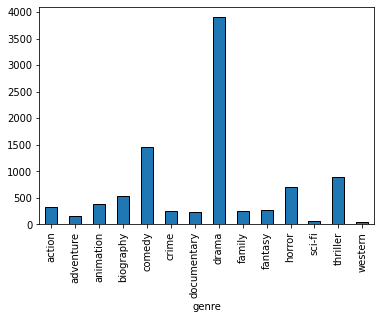

In [38]:
## The same as with imdb dataset (right now at least)
df_filmweb_sampled.groupby("genre").size().plot.bar(edgecolor="k")
plt.show()

Let's check for average number of words by genre in two datasets

In [39]:
df_filmweb_sampled["words_per_description"] = df_filmweb_sampled["description"].str.split().apply(len)
df_imdb_all_sampled["words_per_description"] = df_imdb_all_sampled["description"].str.split().apply(len)

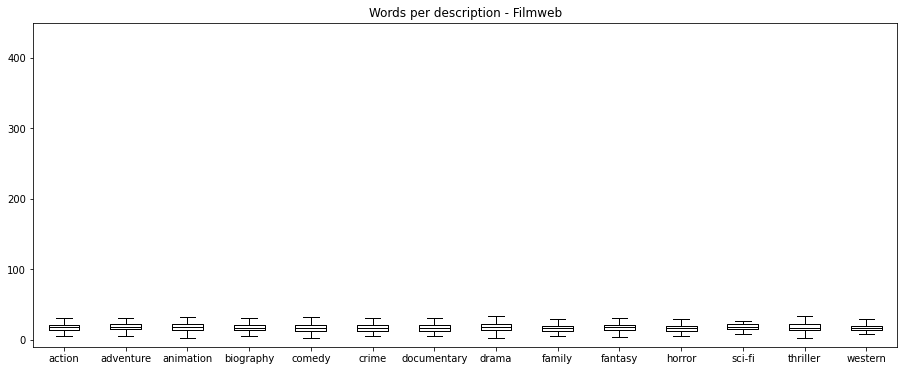

In [40]:
df_filmweb_sampled.boxplot("words_per_description", by="genre", grid=False,
showfliers=False, color="black", figsize=(15, 6))
plt.ylim((-10, 450))
plt.title("Words per description - Filmweb")
plt.suptitle("")
plt.xlabel("")
plt.show()

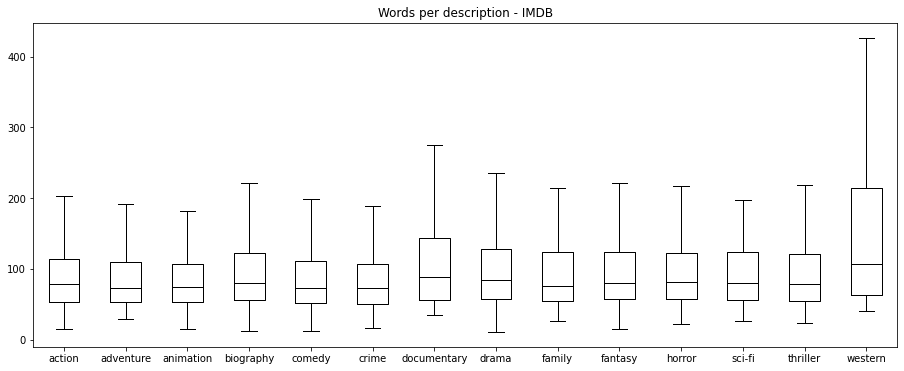

In [41]:
df_imdb_all_sampled.boxplot("words_per_description", by="genre", grid=False,
showfliers=False, color="black", figsize=(15, 6))
plt.title("Words per description - IMDB")
plt.suptitle("")
plt.xlabel("")
plt.show()